# CS 224U Final Project: Relation Extraction with Graph Embeddings

**Authors:** Ben Barnett and Aakash Pattabi

In [81]:
import numpy as np
import json
import sys
from pycorenlp import StanfordCoreNLP
from collections import defaultdict
import subprocess
import sys
import random
import pandas as pd
import pickle
import os

### 1. Loading TACRED data

In [82]:
train_path = "tacred/data/json/train.json"
eval_path = "tacred/data/json/dev.json"
test_path = "tacred/data/json/test.json"

with open(train_path, "rb") as f:
    train_data = json.load(f)
    
with open(eval_path, "rb") as f:
    eval_data = json.load(f)
    
with open(test_path, "rb") as f:
    test_data = json.load(f)

In [83]:
print("{} training samples".format(len(train_data)))
print("{} dev samples".format(len(eval_data)))
print("{} test samples".format(len(test_data)))

68124 training samples
22631 dev samples
15509 test samples


### 2. Defining a sentence-level feature extractor

In [136]:
class GraphFeatureExtractor(object):
    def __init__(self, server, parse_level = "basic", 
                 embedding_path = None):
        self.server = server
        self.set_parse_level(parse_level)
        
        # Initialize word embeddings
        if embedding_path:
            self.embedding_path = embedding_path
            self._load_embeddings()
        else:
            self.embedding_path = None
            
        self._reset_class_distribution()
        self._reset_class_labels()
    
    def _reset_class_labels(self):
        self.class_labels = {}
    
    def _reset_class_distribution(self):
        self.class_distribution = defaultdict(int)
        self.sentences_seen = 0
        
    def _load_embeddings(self):
        self.embeddings = {}
        with open(self.embedding_path, "r") as f:
            for line in f:
                tokens = line.split()
                self.embeddings[tokens[0]] = [float(i) for i in tokens[1:]]
    
    def get_class_labels(self):
        return self.class_labels
    
    def set_parse_level(self, parse_level):
        assert parse_level in ["basic", "enhanced", "extra_enhanced"]
        d = {
            "basic" : "basicDependencies",
            "enhanced" : "enhancedDependencies", 
            "extra_enhanced" : "enhancedPlusPlusDependencies"
        }
        self.parse_level = d[parse_level]
    
    def _extract_graph(self, sentence):
        Y = sentence["relation"]
        self.class_distribution[Y] += 1
        self.sentences_seen += 1
        if Y not in self.class_labels:
            self.class_labels[Y] = len(self.class_labels)
        
        # Extract tokens, subsentence (b/w subj->obj tokens)
        tokens = sentence["token"]
        first = min(sentence["subj_start"], sentence["obj_start"])
        second = max(sentence["subj_end"], sentence["obj_end"])
        middle = tokens[first:second+1]

        # Concatenate full sentence and sentence middle (b/w subj->obj tokens)
        full_sentence = " ".join(tokens)
        full_middle = " ".join(middle)
        
        # Parse with Stanford parser
        full_sentence_out = server.annotate(full_sentence, properties = {
            "annotators" : "parse", 
            "outputFormat" : "json"
        })
        middle_out = server.annotate(full_middle, properties = {
            "annotators" : "parse", 
            "outputFormat" : "json"
        })
        
        # Extract graph edgelist
        X_full, full_tokens = self._parse_to_graph(full_sentence_out)
        X_middle, middle_tokens = self._parse_to_graph(middle_out)
        
        # Add word-level GloVe features to graph inputs
        if self.embedding_path:
            X_full["features"] = self._get_embedding_features(full_tokens)
            for k in set().union(*X_full["edges"]): # Error-checking to make sure G2V completes
                assert k in X_full["features"]
            
            X_middle["features"] = self._get_embedding_features(middle_tokens)
            for k in set().union(*X_middle["edges"]): # Error-checking to make sure G2V completes
                assert k in X_middle["features"]
        
        return {"full" : X_full, "middle" : X_middle, "Y" : Y}
        
    def _parse_to_graph(self, parse):                        
        dep_list = parse["sentences"][0][self.parse_level]
        dep_graph = defaultdict(lambda : [])
        for d in dep_list:
                dep_graph[d["governor"]].append(d["dependent"])
        
        parser_tokens = [tok["word"] for tok in parse["sentences"][0]["tokens"]]
        return self._convert_to_edgelist(dep_graph), parser_tokens
    
    def _convert_to_edgelist(self, dep_graph):
        el = {
            "edges" : [[k, vi] for k, v in dep_graph.items() for vi in v] 
        }        
        return el
    
    def _get_embedding_features(self, sent, embedding_dim = 50):
        feats = {}
        for i, token in enumerate(sent):
            features = self.embeddings.get(token, None)
            if not features:
                features = [np.random.rand() for j in range(embedding_dim)]
            feats[i+1] = features
            
        # By default, we assign the [ROOT] token in the parse tree an embedding vector
        # of all zeroes... mostly because I'm not strictly sure what else to do here. @Ben, thoughts?
        feats[0] = [0]*embedding_dim
        return feats
    
    def extract_batch_graphs(self, sentences):
        n_sentences = len(sentences)
        batch = []
        for i, s in enumerate(sentences):
            batch.append(self._extract_graph(s))
            print("Extracted graphs for [{}/{}] sentences...".format(i+1, n_sentences), end = "\r")
            sys.stdout.flush()

        return batch
    
    def extract_resampled_graphs(self, features, total):
        n_to_resample = total - len(features)
        if n_to_resample <= 0:
            return
        
        resampled_features = []
        while n_to_resample > 0:
            feat = random.choice(features)
            rel = feat["Y"]
            frequency = self.class_distribution[rel]/self.sentences_seen
            keep = (np.random.rand() > frequency)
            if keep:
                resampled_features.append(feat)
                n_to_resample -= 1
        return resampled_features
    
    def save_jsons(self, graphs, save_path):
        assert save_path and save_path[-1] == "/"
        for i, g in enumerate(graphs):
            with open(save_path + str(i) + ".json", "w") as f:
                json.dump(g, f)
    
    def concat_with_mean_embedding(self, features, embedding_dicts):
        n, d = features.shape
        mean_embeddings = []
        for i in range(n):
            mean_embeddings.append(np.mean([v for k, v in embedding_dicts[i].items()], axis = 0))
        return np.concatenate((features, mean_embeddings), axis = 1)
    
    def concat_with_sum_embedding(self, features, embedding_dicts):
        n, d = features.shape
        mean_embeddings = []
        for i in range(n):
            mean_embeddings.append(np.sum([v for k, v in embedding_dicts[i].items()], axis = 0))
        return np.concatenate((features, mean_embeddings), axis = 1)

Additional features to implement:
1. ~~Resampling of the original data to augment data size + reduce class imbalance that *doesn't* duplicate Graph2Vec features across repeated samples.~~
2. ~~Creating a full TAC dataset-to-features pipeline that can be deployed on arbitrary data~~ 
3. Incorporation of e.g. parse tree label information into the features. 
4. Classifiers - implement logistic regression, set up as a neural network.

### 3. Defining a full feature-extraction pipeline that can be used on arbitrary data

In [148]:
class FeatureExtractorPipeline(object):
    def __init__(self, fe_args, save_paths):
        self.fe = GraphFeatureExtractor(**fe_args)
        self.save_paths = save_paths
        self.class_labels = None
    
    def _one_hot(self, length, hot):
        a = np.zeros(length)
        a[hot] = 1
        return a
    
    def _extract_training_graphs(self, sentences, total, train_flag):
        feats = self.fe.extract_batch_graphs(sentences)
        if total > len(sentences):
            resampled_feats = self.fe.extract_resampled_graphs(feats, total)
            feats += resampled_feats
            assert len(feats) == total    
        
        self.fe.save_jsons(
            [feat["full"] for feat in feats], 
            self.save_paths[train_flag + "_full_save_path"]
        )
        self.fe.save_jsons(
            [feat["middle"] for feat in feats], 
            self.save_paths[train_flag + "_middle_save_path"]
        )
        
        self.class_labels = self.fe.get_class_labels()
        n_classes = len(self.class_labels)
        Y = [self._one_hot(n_classes, self.class_labels[feat["Y"]]) for feat in feats]
        X_full_embs = [feat["full"]["features"] for feat in feats]
        X_middle_embs = [feat["middle"]["features"] for feat in feats]
        
        return Y, X_full_embs, X_middle_embs
    
    def _extract_training_embeddings(self, 
                                     X_full_embs, X_middle_embs,
                                     train_flag, 
                                     concat = "mean"):
        assert concat in ["mean", "sum", "both"]
        
        success_full = subprocess.call(
            ["python", 
             "graph2vec/src/graph2vec.py", 
             "--input-path", self.save_paths[train_flag + "_full_save_path"], 
             "--output-path", self.save_paths[train_flag + "_full_g2v_path"]]
        )
        assert success_full == 0
        
        success_middle = subprocess.call(
            ["python", 
             "graph2vec/src/graph2vec.py", 
             "--input-path", self.save_paths[train_flag + "_middle_save_path"], 
             "--output-path", self.save_paths[train_flag + "_middle_g2v_path"]]
        )
        assert success_middle == 0
        
        X_full = pd.read_csv(
            self.save_paths[train_flag + "_full_g2v_path"], sep = ",").drop(labels = ["type"], axis = 1)
        X_full = np.array(X_full)
        
        X_middle = pd.read_csv(
            self.save_paths[train_flag + "_middle_g2v_path"], sep = ",").drop(labels = ["type"], axis = 1)
        X_middle = np.array(X_middle)
        
        if concat == "mean" or concat == "both":
            X_full = fe.concat_with_mean_embedding(X_full, X_full_embs)
            X_middle = fe.concat_with_mean_embedding(X_middle, X_middle_embs)
        elif concat == "sum" or concat == "both":
            X_full = fe.concat_with_sum_embedding(X_full, X_full_embs)
            X_middle = fe.concat_with_sum_embedding(X_middle, X_middle_embs)
        
        return X_full, X_middle
    
    def get_class_labels(self):
        return self.class_labels
    
    def extract_features(self, sentences, total = 0, 
                         train_flag = "train", concat = "mean"):
        assert train_flag in ["train", "test"]
        
        print("Building graphs from sentence dependency trees...")
        Y, X_full_embs, X_middle_embs = self._extract_training_graphs(sentences, total, train_flag)
        np.save(self.save_paths["responses"], Y)
        print("Resampled sentence graphs up to {} total examples in the data...".format(len(Y)), end = "\r")
            
        print("Extracting Graph2Vec embeddings and annotationg w/ GloVe vecs...")
        X_full, X_middle = self._extract_training_embeddings(X_full_embs, X_middle_embs, train_flag, concat)
        X = np.concatenate((X_full, X_middle), axis = 1)
        np.save(self.save_paths["features"], X)
        print("Done!")
        return Y, X_full, X_middle

In [153]:
sanity_check = train_data[:100]

fe_args = {
    "server" : server, 
    "embedding_path" : embedding_path
}

save_paths = {
    "train_full_save_path" : "train_features_full/", 
    "train_middle_save_path" : "train_features_middle/",
    "test_full_save_path" : "test_features_full/",
    "test_middle_save_path" : "test_features_middle/",
    "train_full_g2v_path" : "train_features_full_g2v/features.csv",
    "train_middle_g2v_path" : "train_features_middle_g2v/features.csv",
    "test_full_g2v_path" : "test_features_full_g2v/features.csv", 
    "test_middle_g2v_path" : "test_features_middle_g2v/features.csv",
    "responses" : "all_features/responses",
    "features" : "all_features/features"
}

n_samples = len(sanity_check)
print("Originally {} samples in training data...".format(n_samples))
fep = FeatureExtractorPipeline(fe_args, save_paths)
Y, X_full, X_middle = fep.extract_features(sanity_check, total = 1000)

Originally 100 samples in training data...
Building graphs from sentence dependency trees...
Resampled up to 1000 graphs... sentences...
Extracting Graph2Vec embeddings and annotationg w/ GloVe vecs...
Done!


Let's just verify really quickly that:
1. The one-hot encoding of the labels is correct. 
2. Resampling _did_ fix any class-imbalance issues (if there were any)...

Sentence: Manning was prime minister in 1991 , and called a snap elections in 1995 which he lost to the UNC after the party entered an electoral arrangement with the National Alliance for Reconstruction .
Label: no_relation
FEP label: no_relation
# classes: 12
{0: 'org:founded_by', 1: 'no_relation', 2: 'per:employee_of', 3: 'org:alternate_names', 4: 'per:cities_of_residence', 5: 'per:children', 6: 'per:title', 7: 'per:siblings', 8: 'per:religion', 9: 'per:age', 10: 'org:website', 11: 'per:stateorprovinces_of_residence'}


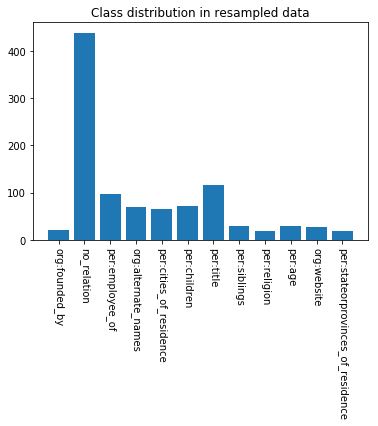

1000
(1000, 178)
(1000, 178)


In [162]:
import matplotlib.pyplot as plt

# Verifying that the labels are correct
idx = random.choice(range(len(sanity_check)))
ex = " ".join(sanity_check[idx]["token"])
label = sanity_check[idx]["relation"]
print("Sentence: {}\nLabel: {}".format(ex, label))

class_labels = { v : k for k, v in fep.get_class_labels().items()}
fep_label = class_labels[np.argmax(Y[idx]).astype(int)]
print("FEP label: {}".format(fep_label))
assert fep_label == label

print("# classes: {}".format(len(class_labels)))
print(class_labels)
# Verifying class-imbalance issues
labels = np.argmax(Y, axis = 1)
keys, counts = np.unique(labels, return_counts = True)
plt.bar(keys, counts)
plt.title("Class distribution in resampled data")
plt.xticks(keys, [class_labels[k] for k in keys], rotation = 270)
plt.show()

# Verifying that all the shapes work out...
print(len(Y))
print(X_full.shape)
print(X_middle.shape)

### 4. Defining the model

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FullyConnectedNN(nn.Module):
    def __init__(self, architecture, input_size, output_size):
        super().__init__()
        architecture = [input_size] + architecture
        self.layers = nn.ModuleList()
        for i, neurons in enumerate(architecture[:-1]):
            self.layers.append(nn.Linear(architecture[i], architecture[i+1]))
        self.output_layer = nn.Linear(architecture[-1], output_size)
        
    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = F.relu(layer(x))
        return self.output_layer(x)

Let's sanity-check just to make sure the network's forward pass is functional...

In [4]:
net = FullyConnectedNN([5, 5, 5], 10, 2)
x = torch.rand(10).view(1, -1)
y = net(x)
print(y)

tensor([[0.4531, 0.0169]], grad_fn=<AddmmBackward>)


Finally, we write the training loop...

In [54]:
class Trainer(object):
    def __init__(self, model, optimizer, hyperparams):
        self.model = model
        self.hyperparams = hyperparams
        self.optimizer = optimizer(model.parameters(), hyperparams["lr"])
    
    def train(X, Y):
        pass